In [1]:
import sys
import time

In [2]:
import tensorflow as tf
import keras
from keras import layers
import keras_tuner as kt
import numpy as np
from PIL import Image

In [3]:
sys.modules['Image'] = Image

In [4]:
tf.get_logger().setLevel('ERROR')

In [5]:
import os

# folders = ("H", "S", "U", "FG", "OP", "P", "C")
folders = ("H", "S", "U", "F", "P", "C", "O", "0")

num_skipped = 0
for folder_name in folders:
    folder_path = os.path.join("Signs", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("PNG") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [28]:
image_size = (40, 64)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    "Signs",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = keras.utils.image_dataset_from_directory(
    "Signs",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 133793 files belonging to 8 classes.
Using 107035 files for training.
Found 133793 files belonging to 8 classes.
Using 26758 files for validation.


In [33]:
class_names = train_ds.class_names
print(len(np.concatenate([i for x, i in train_ds], axis=0)))
print(class_names)

107035
['0', 'C', 'F', 'H', 'O', 'P', 'S', 'U']


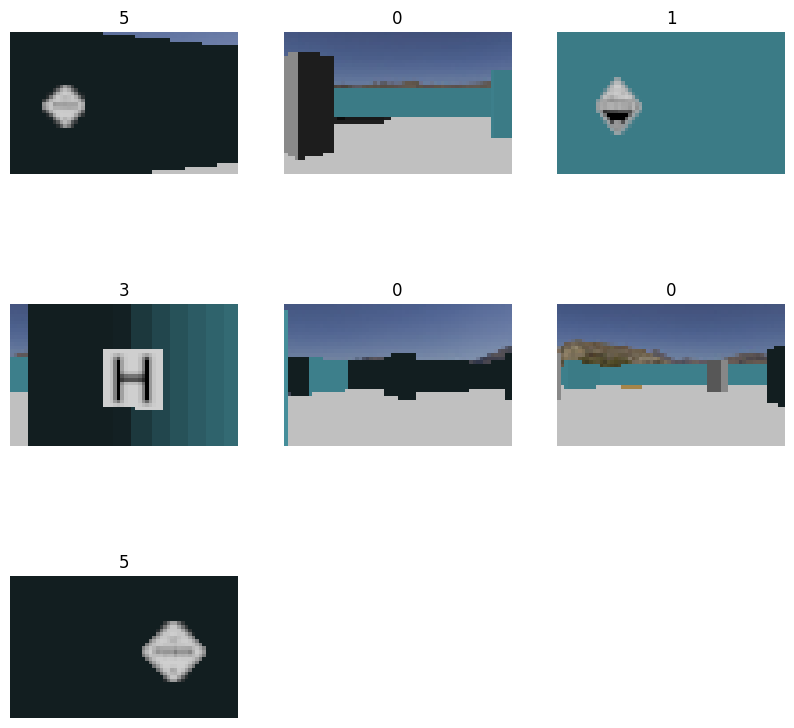

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [35]:
input_shape=image_size + (3,)
num_classes=len(folders)
epochs = 30

In [40]:
def model_builder(hp):
    hp_last_units = hp.Int('units', min_value=32, max_value=768, step=32)
    hp_last_activation = hp.Choice("activation", ["relu", "tanh", "softmax"])
    hp_dropout_rate = hp.Choice("hp_dropout_rate", values=[.05, .1, .15, .2, .25, .3])

    model_layers = [
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(hp_dropout_rate),
        layers.Flatten(),
        layers.Dense(hp_last_units, activation=hp_last_activation),
        layers.Dense(num_classes, name="outputs")
    ]
    model_layers = list(filter(lambda item: item is not None, model_layers))
    model = keras.Sequential(model_layers)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

In [41]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=8,
    factor=3,
    directory='kt',
    project_name='erebus'
)

In [42]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [43]:
tuner.search(train_ds, validation_data=val_ds, epochs=epochs, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 1 Complete [00h 02m 00s]
val_accuracy: 0.9956648349761963

Best val_accuracy So Far: 0.9956648349761963
Total elapsed time: 00h 02m 00s


In [44]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.001.



In [52]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/20
3345/3345 [==============================] - 62s 18ms/step - loss: 0.1004 - accuracy: 0.9684 - val_loss: 0.0884 - val_accuracy: 0.9694
Epoch 2/20
3345/3345 [==============================] - 58s 17ms/step - loss: 0.0299 - accuracy: 0.9909 - val_loss: 0.0184 - val_accuracy: 0.9945
Epoch 3/20
3345/3345 [==============================] - 58s 17ms/step - loss: 0.0246 - accuracy: 0.9928 - val_loss: 0.0470 - val_accuracy: 0.9870
Epoch 4/20
3345/3345 [==============================] - 58s 17ms/step - loss: 0.0198 - accuracy: 0.9944 - val_loss: 0.0150 - val_accuracy: 0.9963
Epoch 5/20
3345/3345 [==============================] - 58s 17ms/step - loss: 0.0177 - accuracy: 0.9949 - val_loss: 0.1537 - val_accuracy: 0.9652
Epoch 6/20
3345/3345 [==============================] - 59s 18ms/step - loss: 0.0184 - accuracy: 0.9953 - val_loss: 0.0207 - val_accuracy: 0.9947
Epoch 7/20
3345/3345 [==============================] - 59s 18ms/step - loss: 0.0116 - accuracy: 0.9966 - val_loss: 0.0639 -

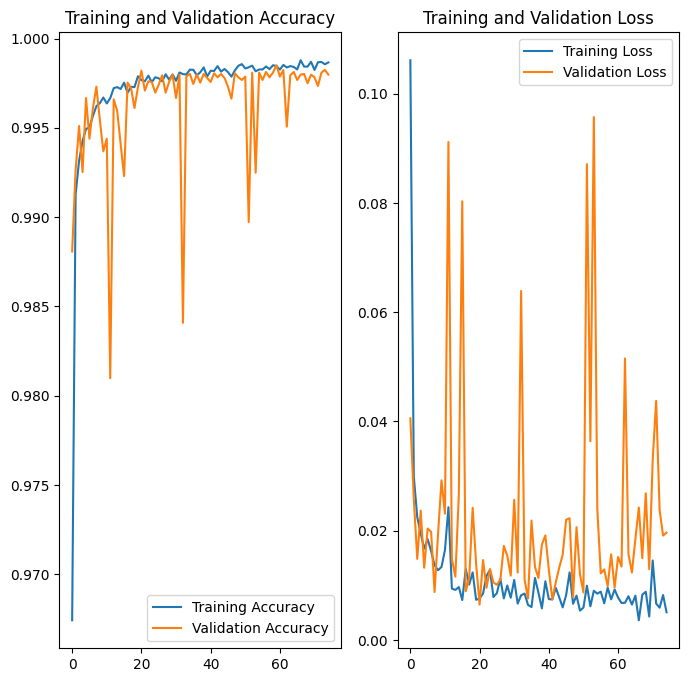

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
model.save('test_ffff-hp.keras')